<a href="https://colab.research.google.com/github/vitaliy-sharandin/data_science_projects/blob/master/portfolio/eda/Global_pollution_and_temperature_phenomena_influence_on_Krakow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Global pollution and local temperature phenomena influence on Krakow EDA
This project's purpose is to analyse global CO2 pollution level and its correlation with temperature's rise globally and in Krakow as well as to analyse most prominent local exhaust pollutants(NO2, CO) levels and how they behave throughout seasons in Krakow.

# Datasets

Global
* Temperature
  * https://climatedata.imf.org/datasets/4063314923d74187be9596f10d034914_0/explore
* Emmissions
  * https://ourworldindata.org/co2-and-greenhouse-gas-emissions
  * https://github.com/owid/co2-data

Krakow
* Temperature
  * https://danepubliczne.imgw.pl/data/dane_pomiarowo_obserwacyjne/dane_meteorologiczne/miesieczne/klimat/
* Emissions
  * https://powietrze.gios.gov.pl/pjp/archives
* Data parsing methods
  * https://github.com/vitaliy-sharandin/data_science_projects/blob/master/utils/krakow_pollution_data_parser.py

In [ ]:
!pip install -U -q datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.6/519.6 kB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 10.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 8.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 13.3 MB/s eta 0:00:00


In [ ]:
import pandas as pd
from datasets import load_dataset, Dataset
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.seasonal import seasonal_decompose

This project was quite challenging in terms of search for most up-to-date data and its cleaning. Here is a brief description of datasets and their discrepancies.
* Global temperature datasets are annual up to year 2022, pollution datasets are annual up to 2021.
* Krakow data is originally monthly and updated up to September 2023.

In [ ]:
global_temp_anomaly_df = load_dataset("vitaliy-sharandin/climate-global-temp-anomaly")['train'].to_pandas().set_index('dt')
country_temp_df = load_dataset("vitaliy-sharandin/climate-global-temp-country")['train'].to_pandas().set_index('dt')
krakow_temp_df = load_dataset("vitaliy-sharandin/climate-krakow-temp-monthly")['train'].to_pandas().set_index('dt')

pollution_region_df = load_dataset("vitaliy-sharandin/pollution-by-region")['train'].to_pandas().set_index('dt')
pollution_variation_df = load_dataset("vitaliy-sharandin/pollution-absolute-variation-co2")['train'].to_pandas().set_index('dt')
pollution_krakow_df = load_dataset("vitaliy-sharandin/pollution-krakow-no2-co")['train'].to_pandas().set_index('dt')

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/519 [00:00<?, ? examples/s]

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/62 [00:00<?, ? examples/s]

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/872 [00:00<?, ? examples/s]

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/31349 [00:00<?, ? examples/s]

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/28944 [00:00<?, ? examples/s]

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/284 [00:00<?, ? examples/s]

In [ ]:
def get_monthly_to_yearly_relative_df(relative_start, relative_end, partial_year_start, partial_year_end, df):
  average_slice = df.loc[relative_start:relative_end]
  relative_average = average_slice.resample('Y').mean().mean()
  yearly_averages = df.resample('Y').mean()
  end_of_full_years = (pd.to_datetime(partial_year_start) - pd.DateOffset(months=1)).strftime('%Y-%m-%d')
  yearly_temp_df = yearly_averages.loc[:end_of_full_years] - relative_average
  partial_year_end_dt = pd.to_datetime(partial_year_end)
  partial_months_average = average_slice.loc[average_slice.index.month <= partial_year_end_dt.month].resample('Y').mean().mean()
  relative_months_df = df.loc[partial_year_start:partial_year_end] - partial_months_average

  return yearly_temp_df.append(pd.DataFrame([relative_months_df.mean()], index=[partial_year_end_dt]))

In [ ]:
def get_monthly_relative_df(start, end, df):
  monthly_averages = df.loc[start:end].groupby(df.loc[start:end].index.month).mean()
  mapped_averages = df.index.map(lambda x: monthly_averages.loc[x.month])
  mapped_averages_df = pd.DataFrame(mapped_averages.tolist(), index=df.index)
  return df - mapped_averages_df

First, we need to convert pure monthly Krakow temperature and pollution to relative one to certain period. In our case monthly mean values from period 1951-1980 were chosen as baseline.

In [ ]:
krakow_yearly_relative_temp_df = get_monthly_to_yearly_relative_df('1951-01-01', '1980-01-01','2023-01-01','2023-08-01', krakow_temp_df)
krakow_monthly_relative_temp_df = get_monthly_relative_df('1951-01-01', '1980-01-01', krakow_temp_df)

pollution_region_df = pollution_region_df.pivot(columns='Entity', values='Annual CO₂ emissions')[['World','European Union (27)','Poland','United States', 'India', 'China']]
pollution_variation_df = pollution_variation_df.pivot(columns='Entity', values='Annual CO₂ emissions growth (abs)')[['World','European Union (27)','Poland','United States', 'India', 'China']]

pollution_krakow_df = pollution_krakow_df[pollution_krakow_df.index.year >= 2004]
krakow_yearly_relative_pollution_df = get_monthly_to_yearly_relative_df('2004-01-01', '2009-01-01','2023-01-01','2023-08-01', pollution_krakow_df)
krakow_monthly_relative_pollution_df = get_monthly_relative_df('2004-01-01', '2009-01-01', pollution_krakow_df)

<ipython-input-4-9312066b517b>:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return yearly_temp_df.append(pd.DataFrame([relative_months_df.mean()], index=[partial_year_end_dt]))
<ipython-input-4-9312066b517b>:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return yearly_temp_df.append(pd.DataFrame([relative_months_df.mean()], index=[partial_year_end_dt]))


# CO2 pollution and greenhouse effect on global temperatures

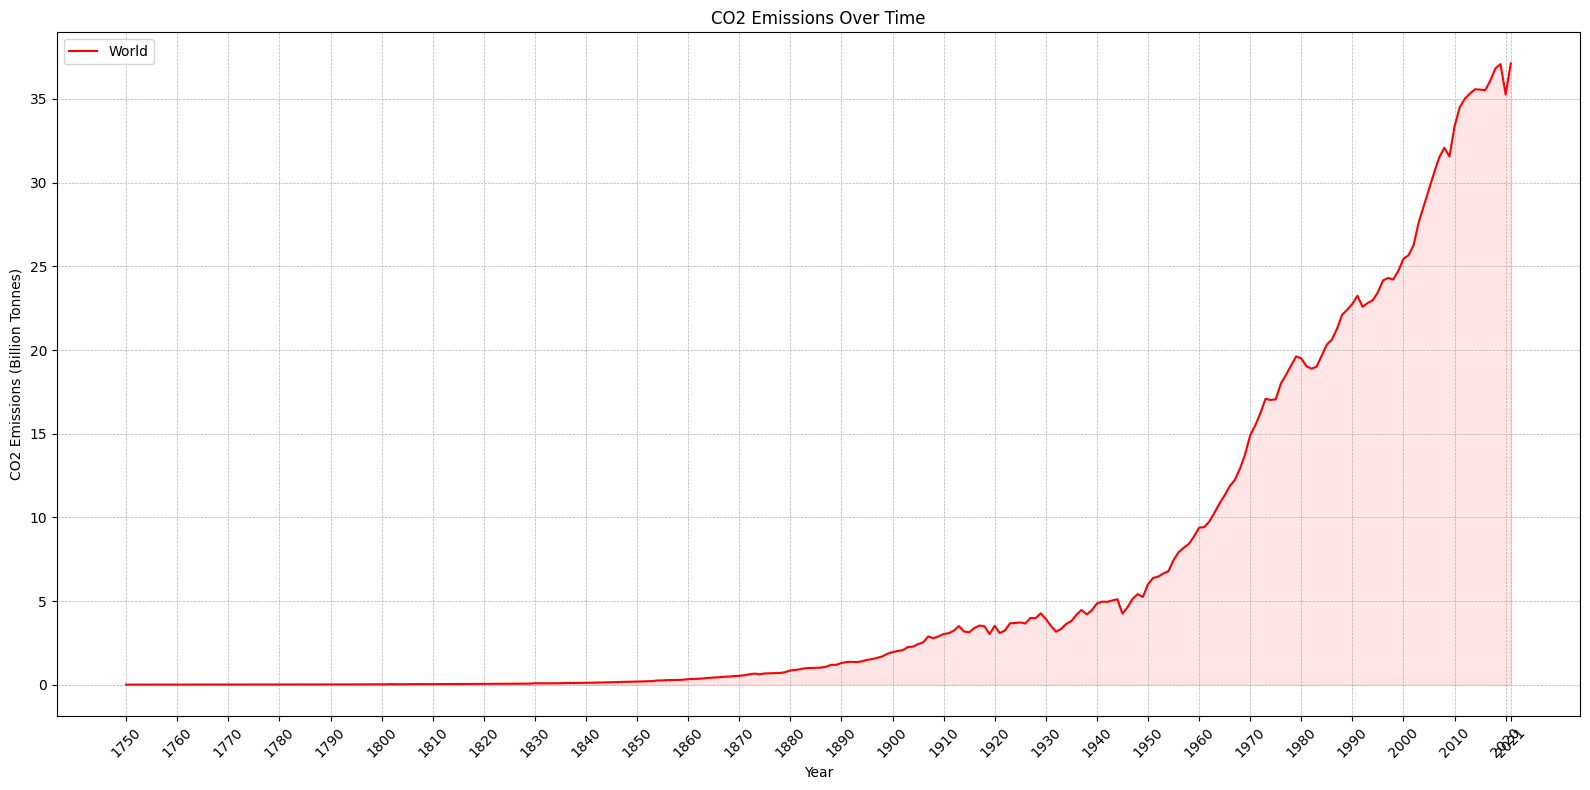

In [ ]:
country_color_dict = {
    "World": "red"
}

pollution_region_df_clean = pollution_region_df.dropna(subset=list(country_color_dict.keys()), how='all')

all_years = pollution_region_df_clean.index.year.unique()
ticks_years = [year for year in all_years if year % 10 == 0] + [max(all_years)]
tick_dates_clean = pollution_region_df_clean[pollution_region_df_clean.index.year.isin(ticks_years)].index.unique()

plt.figure(figsize=(16, 8))

for country, color in country_color_dict.items():
    data_values = pollution_region_df_clean[country] / 1e9
    sns.lineplot(data=pollution_region_df_clean, x=pollution_region_df_clean.index, y=data_values, label=country, color=color)
    plt.fill_between(pollution_region_df_clean.index, data_values, color=color, alpha=0.1)

plt.title("CO2 Emissions Over Time")
plt.xlabel("Year")
plt.ylabel("CO2 Emissions (Billion Tonnes)")
plt.legend()
plt.grid(True, which="both", linestyle="--", linewidth=0.5)

plt.xticks(tick_dates_clean, labels=[date.year for date in tick_dates_clean], rotation=45)

plt.tight_layout()
plt.show()

The graph represents the trajectory of CO2 emissions worldwide, spanning from 1750 to 2021.

* For a prolonged period, from around 1750 until the late 19th century, global CO2 emissions remained relatively stagnant, hovering close to zero billion tonnes.
* A noticeable, albeit gradual, increase in CO2 emissions began around the late 1800s, which aligns with the onset of the industrial revolution.
* The 20th century saw a significant uptick in the rate of emissions, particularly post the 1950s. This surge can be attributed to rapid industrialization, increased reliance on fossil fuels, and urbanization on a global scale.
* In recent years, the curve has become steeper, indicating an alarming acceleration in CO2 emissions, surpassing 30 billion tonnes around 2021.
* Also, at the end of 2020 we can see the drop in global CO2 emissions most likely due to halt in human acivities and transportation with the rise of Corona virus.

Now, let's see how the contributions to pollution spread across biggest countries and unions as well as Poland.

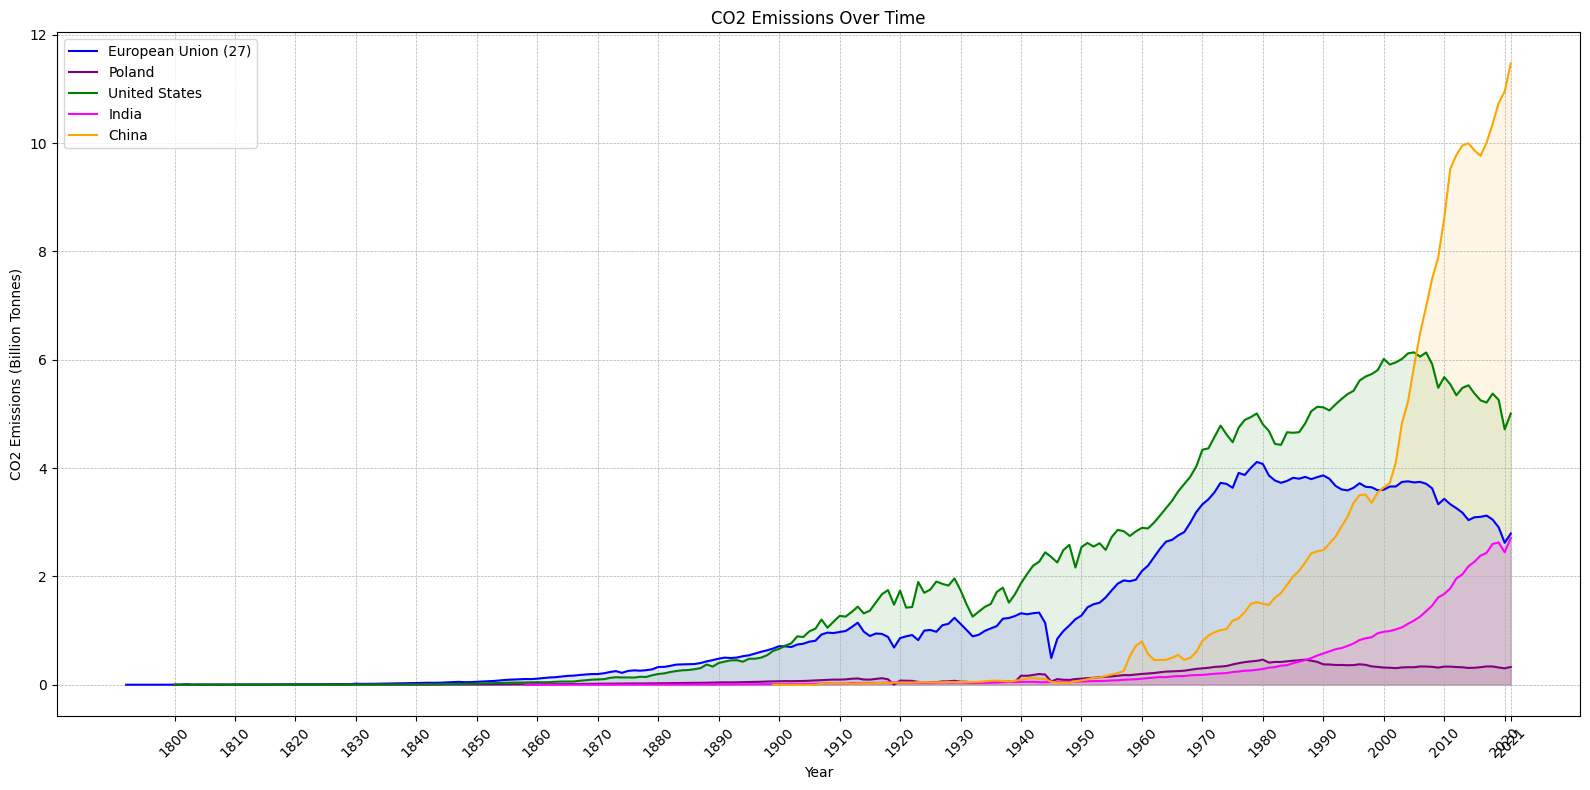

In [ ]:
country_color_dict = {
    "European Union (27)": "blue",
    "Poland": "purple",
    "United States": "green",
    "India": "magenta",
    "China": "orange"
}

pollution_region_df_clean = pollution_region_df.dropna(subset=list(country_color_dict.keys()), how='all')

all_years = pollution_region_df_clean.index.year.unique()
ticks_years = [year for year in all_years if year % 10 == 0] + [max(all_years)]
tick_dates_clean = pollution_region_df_clean[pollution_region_df_clean.index.year.isin(ticks_years)].index.unique()

plt.figure(figsize=(16, 8))

for country, color in country_color_dict.items():
    data_values = pollution_region_df_clean[country] / 1e9
    sns.lineplot(data=pollution_region_df_clean, x=pollution_region_df_clean.index, y=data_values, label=country, color=color)
    plt.fill_between(pollution_region_df_clean.index, data_values, color=color, alpha=0.1)

plt.title("CO2 Emissions Over Time")
plt.xlabel("Year")
plt.ylabel("CO2 Emissions (Billion Tonnes)")
plt.legend()
plt.grid(True, which="both", linestyle="--", linewidth=0.5)

plt.xticks(tick_dates_clean, labels=[date.year for date in tick_dates_clean], rotation=45)

plt.tight_layout()
plt.show()


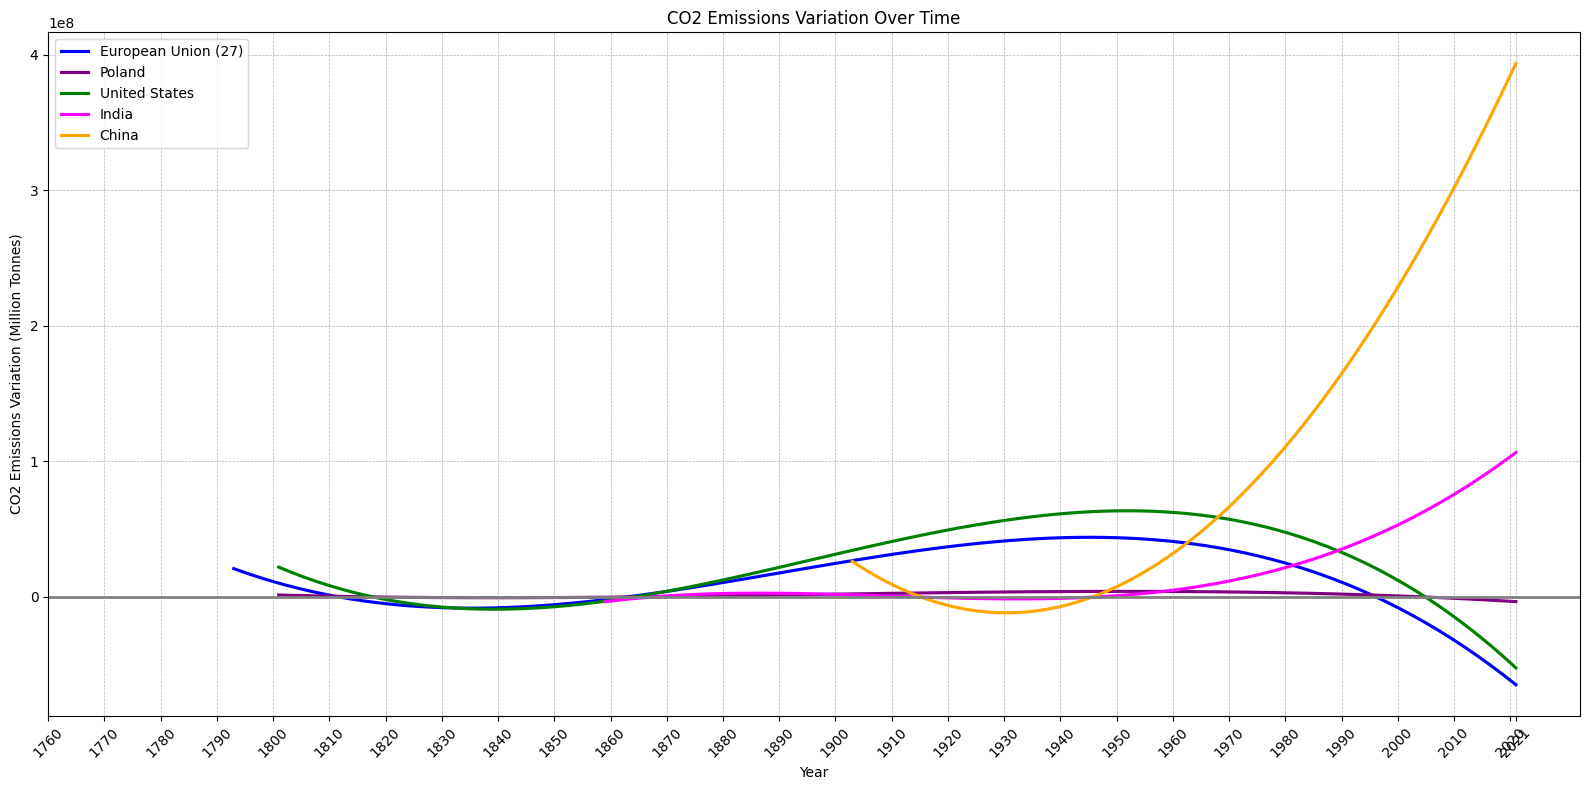

In [ ]:
all_years = pollution_variation_df.index.year.unique()
ticks_years = [year for year in all_years if year % 10 == 0] + [max(all_years)]

plt.figure(figsize=(16, 8))

for country, color in country_color_dict.items():
    x_values = pollution_variation_df.index.year
    y_values = pollution_variation_df[country]

    sns.regplot(x=x_values, y=y_values,
                label=country, color=color, scatter=False, ci=None, order=3)

plt.axhline(0, color='grey', linestyle='-', linewidth=2)
plt.title("CO2 Emissions Variation Over Time")
plt.xlabel("Year")
plt.ylabel("CO2 Emissions Variation (Million Tonnes)")
plt.legend()
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.xticks(ticks_years, rotation=45)
plt.tight_layout()
plt.show()


We can clearly see that USA and European Union trends in emissions are starting to fall, what can indicate striving towards "zero emissions by 2050" policies. China as a world factory has emissions increasing each year still.

<ipython-input-10-4145ac0e1fbc>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  global_temp_filtered['Year'] = global_temp_filtered.index.year


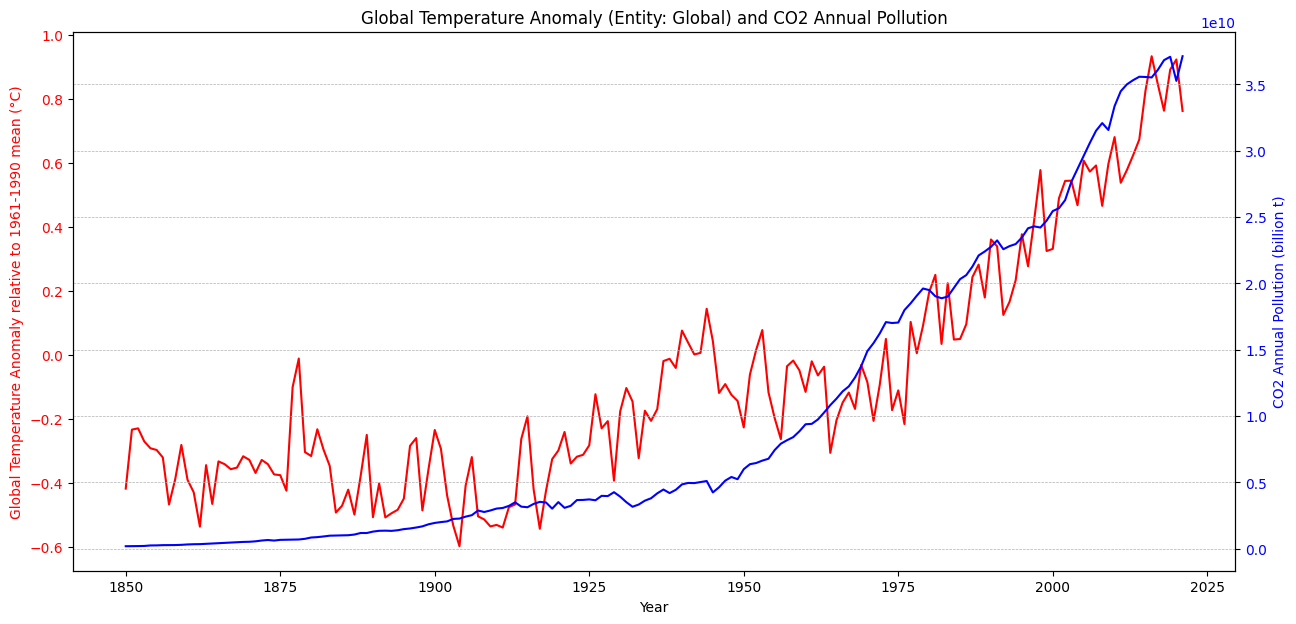

In [ ]:
global_temp_filtered = global_temp_anomaly_df[global_temp_anomaly_df['Entity'] == 'Global']
global_temp_filtered['Year'] = global_temp_filtered.index.year
pollution_region_df['Year'] = pollution_region_df.index.year
pollution_region_df_corr = pollution_region_df[['Year', 'World']]

merged_df_updated = pd.merge(global_temp_filtered, pollution_region_df_corr, on='Year', how='inner')

fig, ax1 = plt.subplots(figsize=(15, 7))

ax1.set_xlabel('Year')
ax1.set_ylabel('Global Temperature Anomaly relative to 1961-1990 mean (°C)', color='red')
ax1.plot(merged_df_updated['Year'], merged_df_updated['Global average temperature anomaly relative to 1961-1990'], color='red', label='Temperature Anomaly')
ax1.tick_params(axis='y', labelcolor='red')

ax2 = ax1.twinx()
ax2.set_ylabel('CO2 Annual Pollution (billion t)', color='blue')
ax2.plot(merged_df_updated['Year'], merged_df_updated['World'], color='blue', label='CO2 Annual Pollution (billion t)')
ax2.tick_params(axis='y', labelcolor='blue')

plt.title('Global Temperature Anomaly (Entity: Global) and CO2 Annual Pollution')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()


On the composite chart of global temperatures and annual pollution we can see that:

* Global Temperature Anomaly fluctuates but shows a clear upward trend since the late 1970s, indicating global warming.
* CO2 Annual Pollution has been steadily increasing from around the late 1800s, with a more pronounced rise from the mid-20th century onwards.
* Both the temperature anomaly and CO2 pollution see significant increases in parallel, especially from the 1950s onwards, suggesting a possible correlation between the two.

<Figure size 1200x800 with 0 Axes>

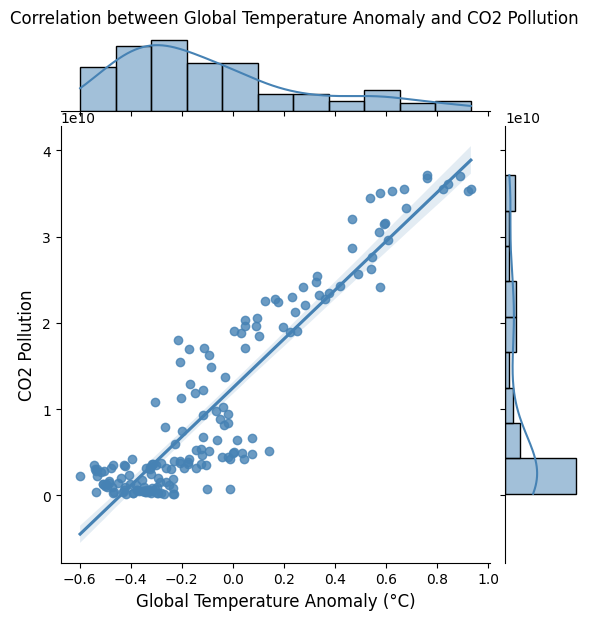

0.9221707125570543

In [ ]:
plt.figure(figsize=(12, 8))
sns_plot = sns.jointplot(data=merged_df_updated,
                         x='Global average temperature anomaly relative to 1961-1990',
                         y='World',
                         kind='reg',
                         color='steelblue')
sns_plot.set_axis_labels('Global Temperature Anomaly (°C)', 'CO2 Pollution', fontsize=12)
plt.suptitle('Correlation between Global Temperature Anomaly and CO2 Pollution', y=1.02)
plt.show()
merged_df_updated[['Global average temperature anomaly relative to 1961-1990', 'World']].corr().iloc[0, 1]

**Insights**:

The scatterplot illustrates the correlation between the Global Temperature Anomaly and CO2 Pollution. The correlation coefficient, given as 0.92, indicates a strong positive linear relationship between the two variables and confirms observations of previous chart with temperatures and pollution rising.

* As the Global Temperature Anomaly increases, CO2 Pollution also rises, as depicted by the positive slope of the data points.
* The histograms on the top (for Global Temperature Anomaly) and right (for CO2 Pollution) provide the distribution of data for each variable. The distribution for both variables is right-skewed meaning that the increase in pollution and temperature are rather recent events.

# Global and local temperatures relationship

We've seen that global temperature is rising indeed and by our most up-to-date scientific knowledge not only correlated with, but also caused by CO2 emissions causing greenhouse effect. But what about temperatures in countries and cities (e.g. Krakow), does temperature rise on smaller scales as well? Let's find out.

<ipython-input-12-00b53861dd31>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  global_only_df["year"] = global_only_df.index.year


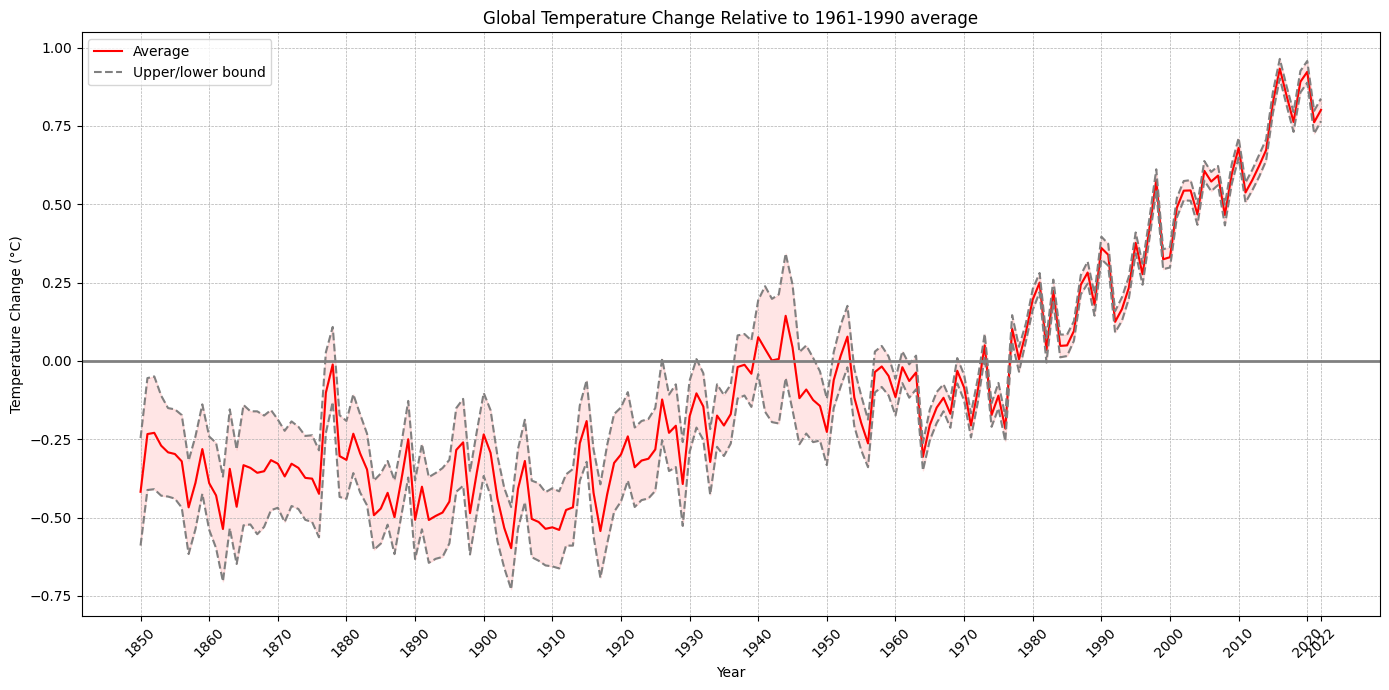

In [ ]:
global_only_df = global_temp_anomaly_df[global_temp_anomaly_df["Entity"] == "Global"]
global_only_df["year"] = global_only_df.index.year

plt.figure(figsize=(14, 7))

mean_col = "Global average temperature anomaly relative to 1961-1990"
upper_col = "Upper bound (95% confidence interval) of the annual temperature anomaly"
lower_col = "Lower bound (95% confidence interval) of the annual temperature anomaly"

plt.fill_between(global_only_df.index,
                 global_only_df[mean_col],
                 global_only_df[upper_col],
                 color="red", alpha=0.1)

plt.fill_between(global_only_df.index,
                 global_only_df[mean_col],
                 global_only_df[lower_col],
                 color="red", alpha=0.1)

sns.lineplot(data=global_only_df, x="dt", y=mean_col, label="Average", color="red")
sns.lineplot(data=global_only_df, x="dt", y=upper_col, label="Upper/lower bound", color="grey", linestyle='--')
sns.lineplot(data=global_only_df, x="dt", y=lower_col, color="grey", linestyle='--')

ticks_df = global_only_df[(global_only_df['year'] % 10 == 0) | (global_only_df['year'] == global_only_df['year'].max())]

plt.axhline(0, color='grey', linestyle='-', linewidth=2)
plt.title("Global Temperature Change Relative to 1961-1990 average")
plt.xlabel("Year")
plt.ylabel("Temperature Change (°C)")
plt.legend()
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.xticks(ticks_df.index, ticks_df['year'],rotation=45)
plt.tight_layout()
plt.show()

**Insights**:
* Historical Temperature Variations: From the mid-1800s to the early 1900s, there were fluctuations in global temperatures, with periods of slight cooling and warming.

* Mid-20th Century Onward: Post the 1950s, there is a more pronounced upward trend in global temperatures. This indicates a consistent increase in global temperature anomalies relative to the 1961-1990 baseline.

* Upper and Lower Bounds: The dashed lines representing the upper and lower bounds signify the range of uncertainty or variance in the temperature data. While there are fluctuations within this range, the general trend aligns with the average, emphasizing the reliability of the observed warming trend.

* Recent Trends: The latter part of the chart (post-2000) shows more frequent peaks, indicating that global temperatures are increasingly surpassing previous records. This is a clear sign of accelerated global warming.

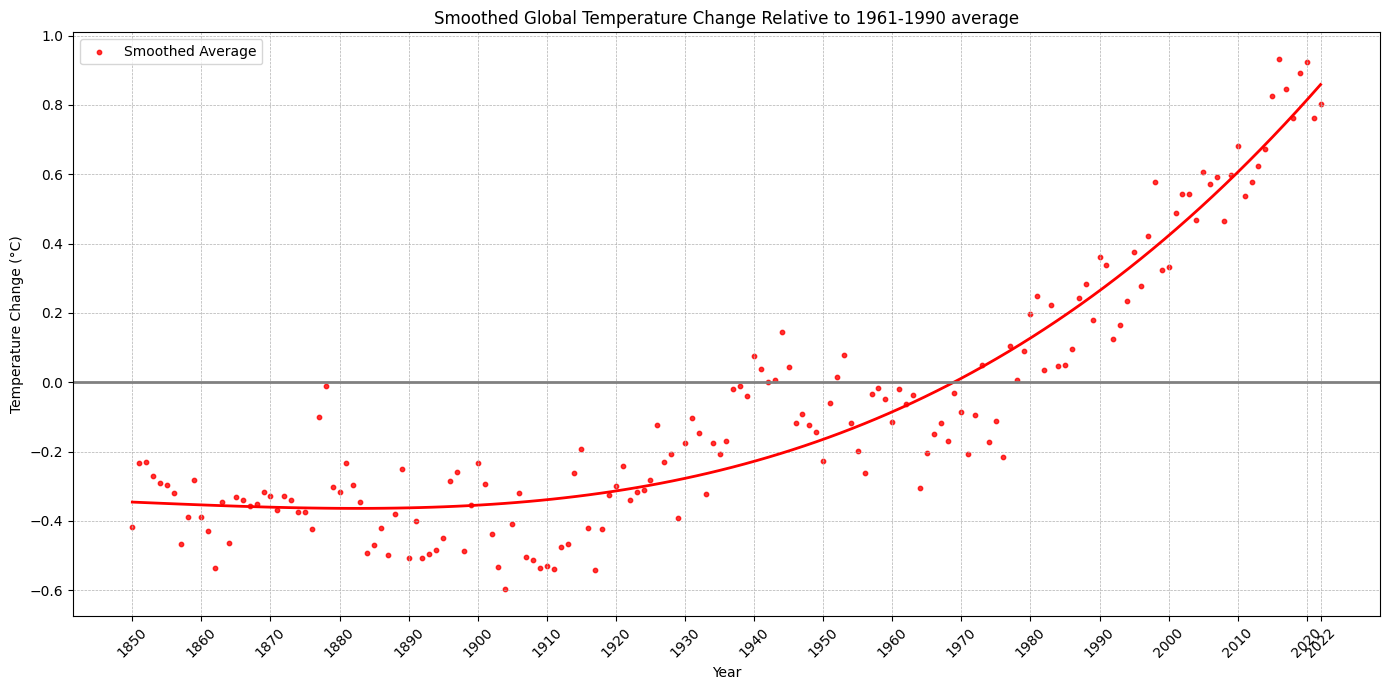

In [ ]:
plt.figure(figsize=(14, 7))

sns.regplot(data=global_only_df, x="year", y="Global average temperature anomaly relative to 1961-1990", label="Smoothed Average", color="red", scatter=True, scatter_kws={"s": 10}, order=3, ci=None, line_kws={'lw': 2})

plt.axhline(0, color='grey', linestyle='-', linewidth=2)
plt.title("Smoothed Global Temperature Change Relative to 1961-1990 average")
plt.xlabel("Year")
plt.ylabel("Temperature Change (°C)")
plt.legend()
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.xticks(ticks_df["year"], rotation=45)
plt.tight_layout()
plt.show()

The trend line clearly indicates temperatures are skyrocketing.

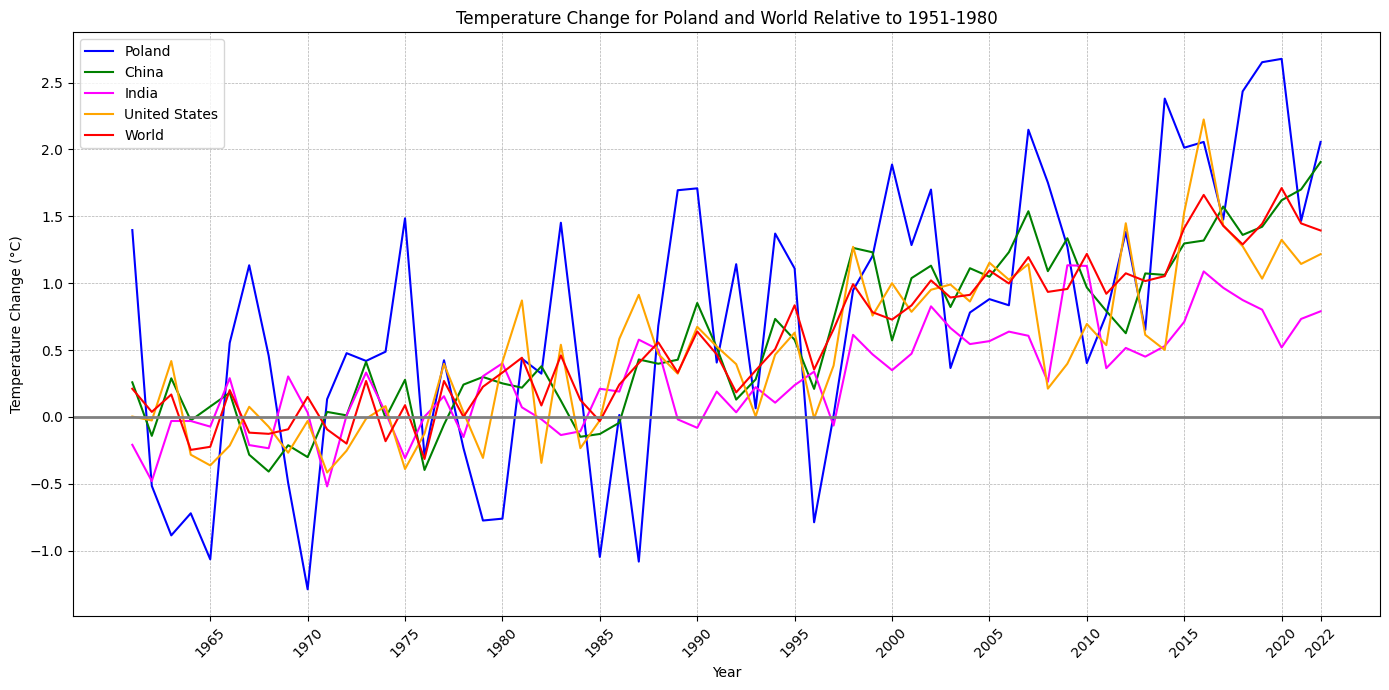

In [ ]:
countries = {
    'Poland': 'blue',
    'China': 'green',
    'India': 'magenta',
    'United States': 'orange',
    'World': 'red'
}

ticks_df_country = country_temp_df[(country_temp_df["Year"] % 5 == 0) | (country_temp_df["Year"] == country_temp_df["Year"].max())]

plt.figure(figsize=(14, 7))

for country, color in countries.items():
    sns.lineplot(data=country_temp_df, x="Year", y=country, label=country, color=color)

plt.axhline(0, color='grey', linestyle='-', linewidth=2)
plt.xticks(ticks_df_country["Year"].unique(), rotation=45)
plt.title("Temperature Change for Poland and World Relative to 1951-1980")
plt.xlabel("Year")
plt.ylabel("Temperature Change (°C)")
plt.legend()
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.tight_layout()
plt.show()


What's interesting in this temperature change chart is that Poland has seen biggest fluctuations out of all countries. The reason might be due to Poland's location in Central Europe which makes it vulnerable to both Atlantic and continental air masses, leading to variations in temperature. Depending on the dominant air mass in a particular year, Poland can experience milder Atlantic conditions or colder and more variable continental conditions.

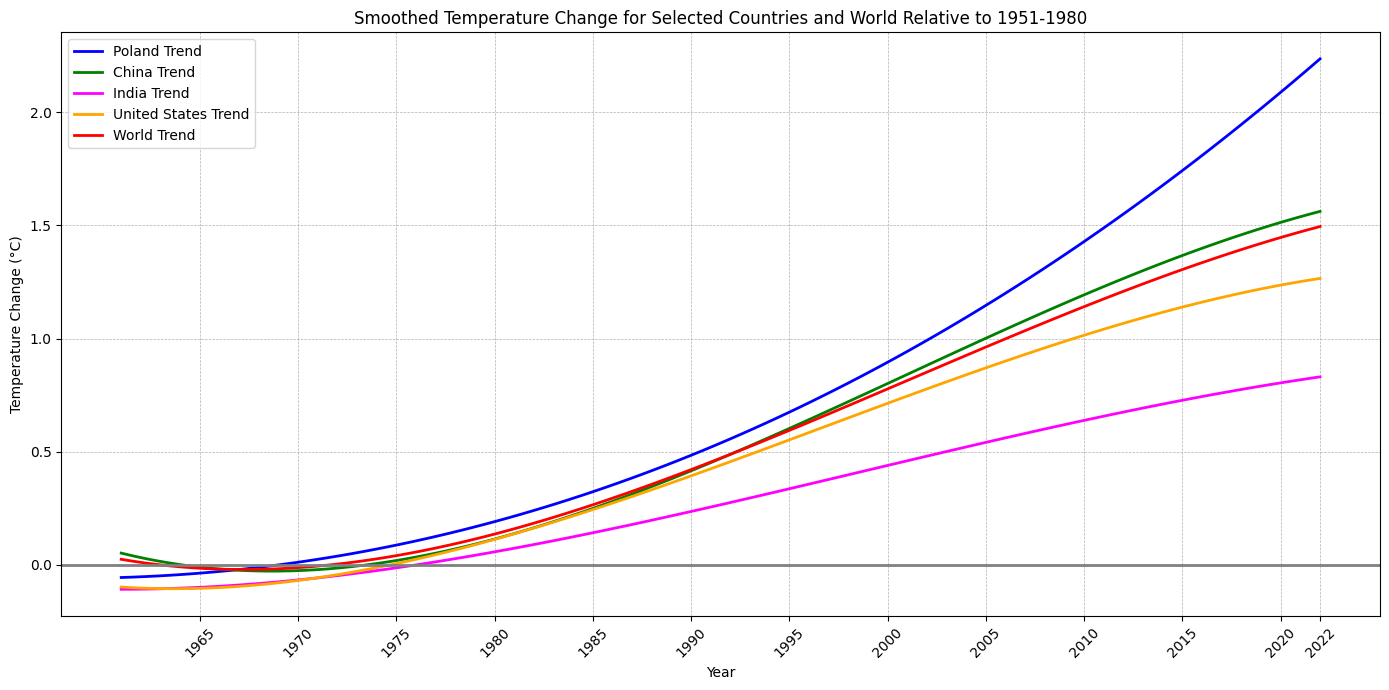

In [ ]:
plt.figure(figsize=(14, 7))

for country, color in countries.items():
    sns.regplot(data=country_temp_df, x="Year", y=country, label=f"{country} Trend", color=color, scatter=False, order=3, ci=None, line_kws={'lw': 2})

plt.axhline(0, color='grey', linestyle='-', linewidth=2)
plt.xticks(ticks_df_country["Year"].unique(), rotation=45)
plt.title("Smoothed Temperature Change for Selected Countries and World Relative to 1951-1980")
plt.xlabel("Year")
plt.ylabel("Temperature Change (°C)")
plt.legend()
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.tight_layout()
plt.show()

Poland's temperatures are on the steepest rise.

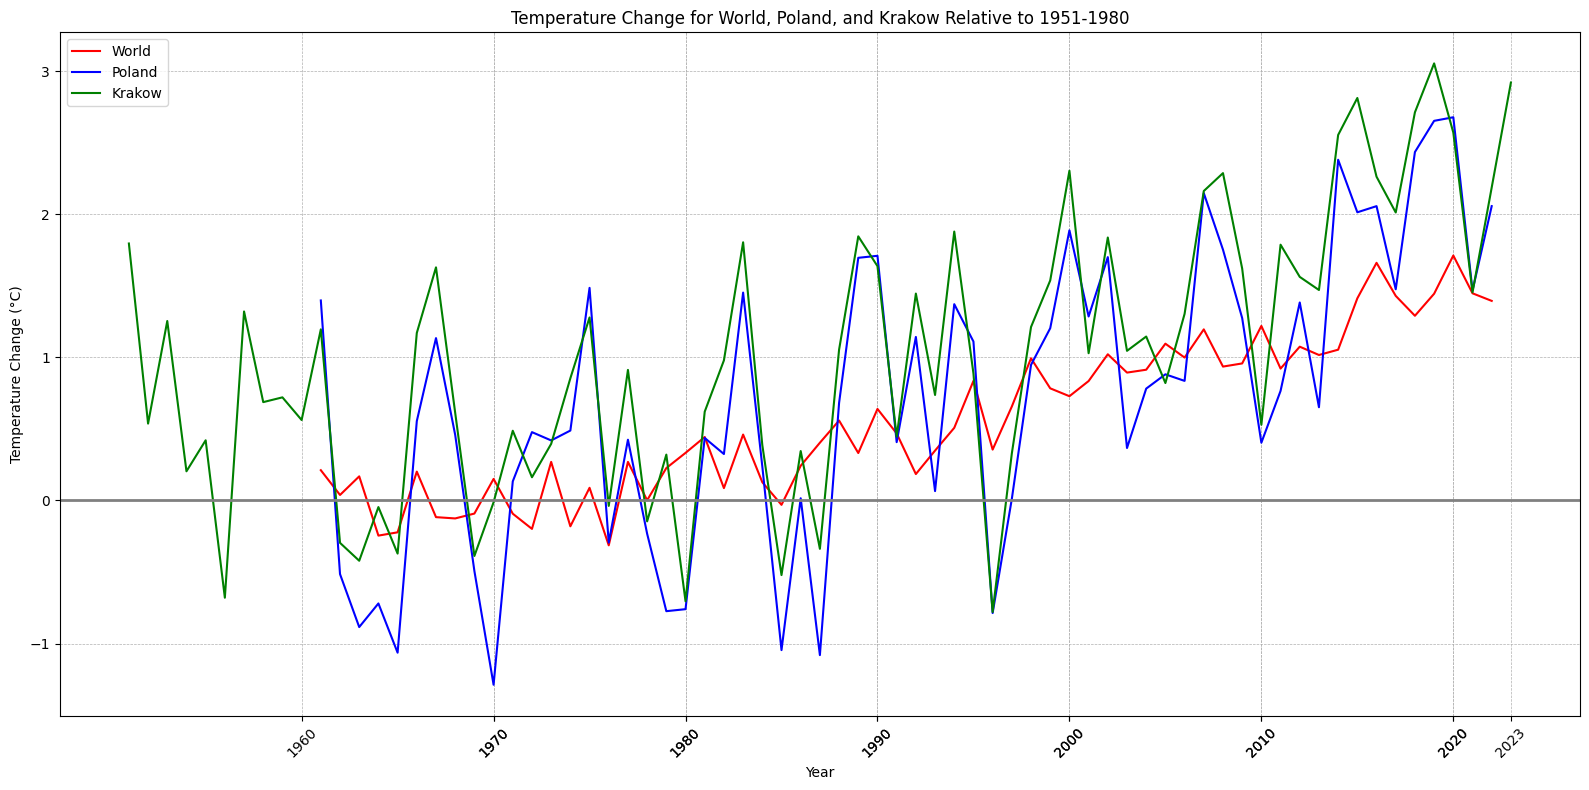

In [ ]:
krakow_yearly_relative_temp_df["year"] = krakow_yearly_relative_temp_df.index.year

plt.figure(figsize=(16, 8))

palette_extended = {
    'World': 'red',
    'Poland': 'blue',
    'Krakow': 'green'
}

for country, color in palette_extended.items():
    if country in ['World', 'Poland']:
        sns.lineplot(data=country_temp_df, x="Year", y=country, label=country, color=color)

sns.lineplot(data=krakow_yearly_relative_temp_df, x="year", y="Average monthly temperature [°C]", label="Krakow", color=palette_extended["Krakow"])

all_years = country_temp_df["Year"].unique().tolist() + krakow_yearly_relative_temp_df["year"].unique().tolist()
ticks_years = [year for year in all_years if year % 10 == 0] + [max(all_years)]

plt.axhline(0, color='grey', linestyle='-', linewidth=2)
plt.xticks(ticks_years, rotation=45)
plt.title("Temperature Change for World, Poland, and Krakow Relative to 1951-1980")
plt.xlabel("Year")
plt.ylabel("Temperature Change (°C)")
plt.legend()
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.tight_layout()
plt.show()


**Insights**:
* Overall Trend: All three lines show a general upward trend, which is consistent with global warming.
* Krakow's temperature data, represented by the green line, indeed shows higher temperatures in recent years compared to the national average of Poland.<br>One of the primary reasons for a city like Krakow to have higher temperatures than the national average is the urban heat island (UHI) effect. This phenomenon occurs when urban areas experience higher temperatures than their rural surroundings due to human activities, dense buildings, concrete surfaces, and reduced vegetation. The heat gets absorbed during the day and is slowly released at night, leading to higher nighttime temperatures.

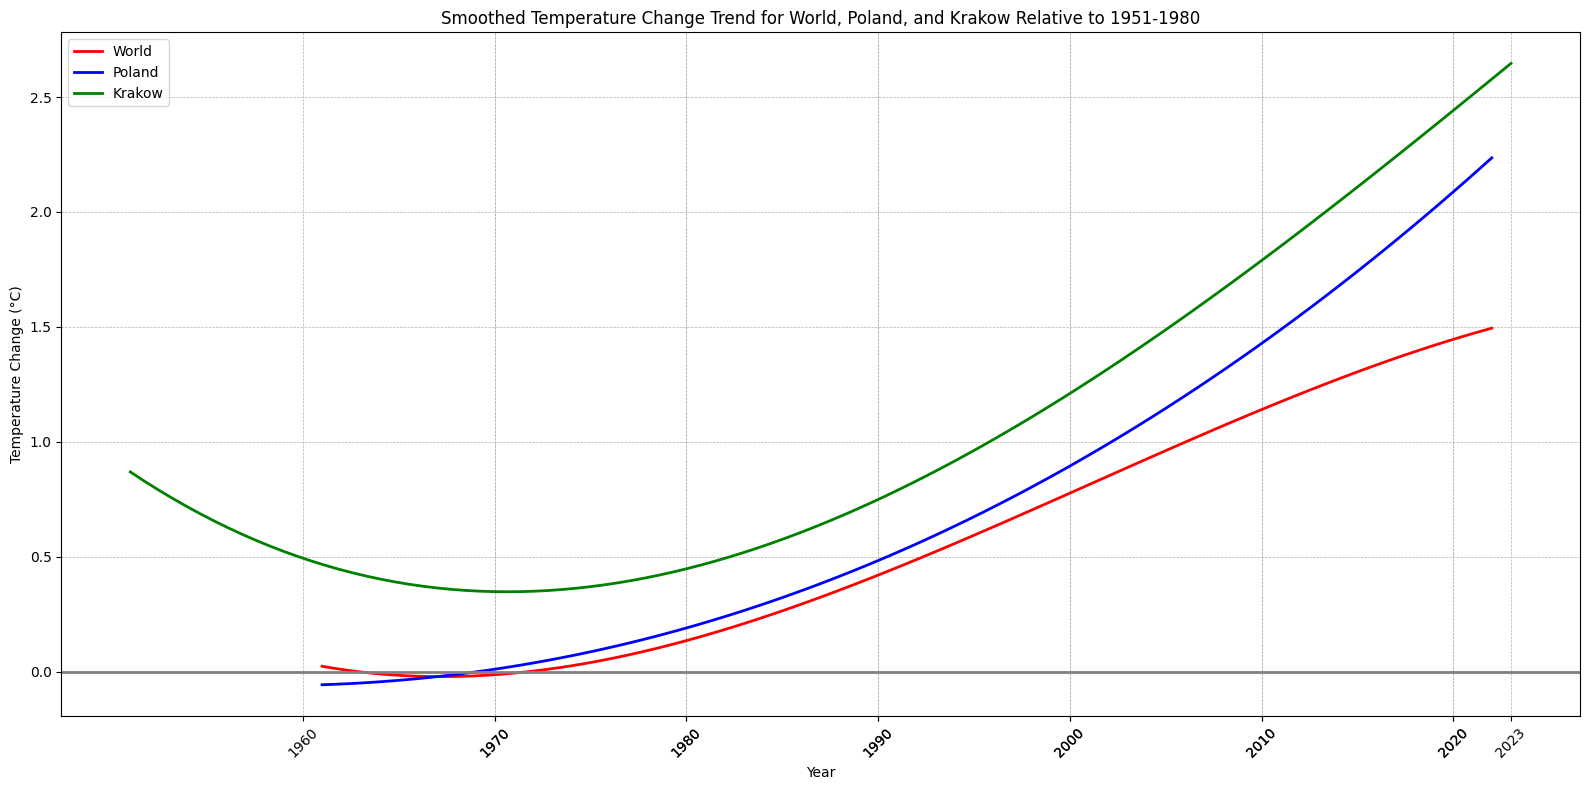

In [ ]:
plt.figure(figsize=(16, 8))

for country, color in palette_extended.items():
    if country in ['World', 'Poland']:
        sns.regplot(data=country_temp_df, x="Year", y=country, label=country, color=color, scatter=False, order=3, ci=None, line_kws={'lw': 2})
    else:
        sns.regplot(data=krakow_yearly_relative_temp_df, x="year", y="Average monthly temperature [°C]", label="Krakow", color=color, scatter=False, order=3, ci=None, line_kws={'lw': 2})

plt.axhline(0, color='grey', linestyle='-', linewidth=2)
plt.xticks(ticks_years, rotation=45)
plt.title("Smoothed Temperature Change Trend for World, Poland, and Krakow Relative to 1951-1980")
plt.xlabel("Year")
plt.ylabel("Temperature Change (°C)")
plt.legend()
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.tight_layout()
plt.show()


The trends are clearly showing Krakow as city having most influence on temperatures rise.

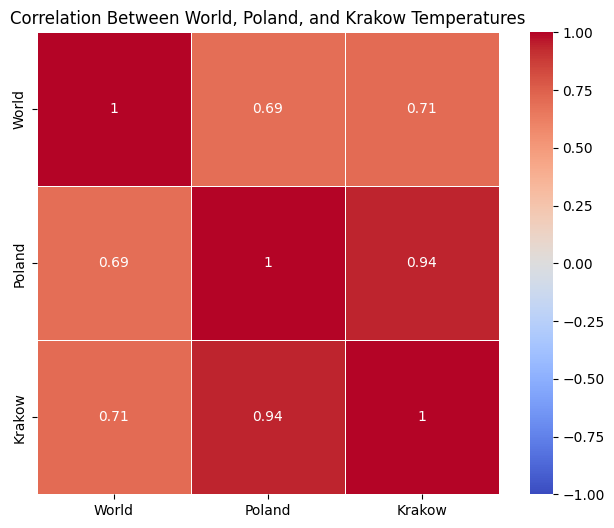

In [ ]:
merged_df = pd.merge(country_temp_df[['Year', 'World', 'Poland']], krakow_yearly_relative_temp_df[['year', 'Average monthly temperature [°C]']], left_on="Year", right_on="year", how="inner")

merged_df.drop(columns=['year'], inplace=True)
merged_df.rename(columns={'Average monthly temperature [°C]': 'Krakow'}, inplace=True)

correlation_matrix = merged_df[['World', 'Poland', 'Krakow']].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, square=True, linewidths=0.5)
plt.title("Correlation Between World, Poland, and Krakow Temperatures")
plt.show()

**Insights**:
* The correlation between Poland and Krakow is the highest, indicating that Krakow's temperature trends are very representative of Poland as a whole.

* Both Poland and Krakow have positive correlations with the world, suggesting that as global temperatures change, temperatures in both Poland and Krakow are affected in a similar direction.

This heatmap provides a clear visual representation of the relationships between these temperature datasets. It can be inferred that global warming trends are influencing both Poland and Krakow, with Krakow's trends aligning slightly more with global patterns.

# Krakow NO2 and CO pollution concentration and heat inversion effect

Previously we've researched influence of global pollution on global and local temperatures. Now, let's see how local temperature phenomena can influence local pollution.

The phenomenon we are dealing with is called surface based temperature inversion(SBTI). A temperature inversion is a layer in the atmosphere in which air temperature increases with height. An inversion is present in the lower part of a cap. The cap is a layer of relatively warm air aloft (above the inversion).
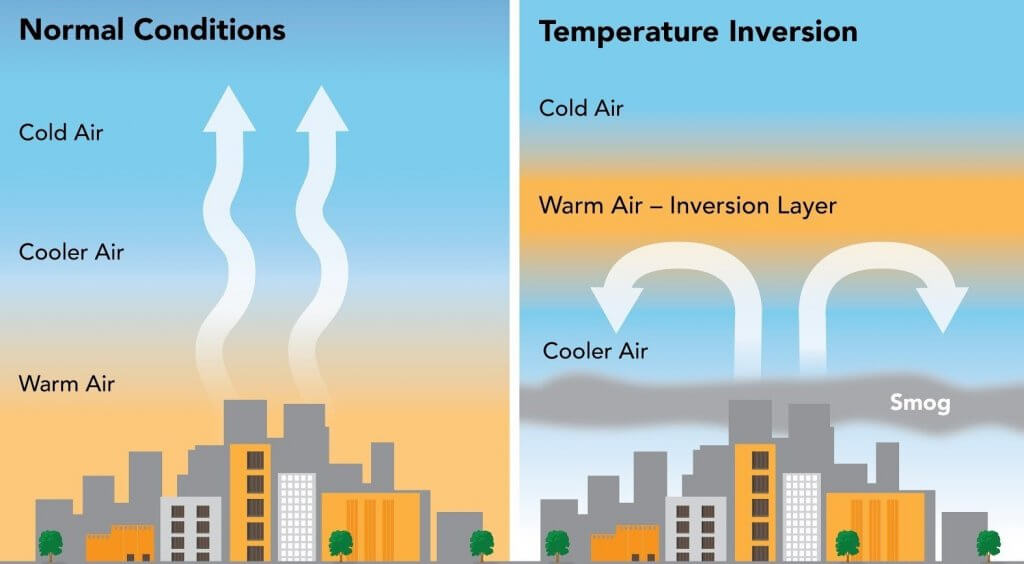

It is known that Krakow is also a subject to heat inversions as well as high pollution levels in general and especially during winter months. Also, there is a study which has researched heat inversions in Poland.

https://link.springer.com/article/10.1007/s00704-021-03752-4

According to study, SBTIs occur less frequently at night in winter (23-38% of nights) compared to other seasons like summer (64-75% of nights).
However, **winter SBTIs tend to be stronger and penetrate deeper** into the atmosphere compared to other seasons. The depth range of SBTIs was largest in winter (114-309m). Winter nights are colder, allowing for stronger radiative cooling at the surface to drive intense SBTIs. Emissions are also higher in winter from heating. Hence, due to all these factors winter is a season of heightened pollution.

Let's see for ourselves if analysis of NO2 and CO exhaust pollutants will confirm these claims.

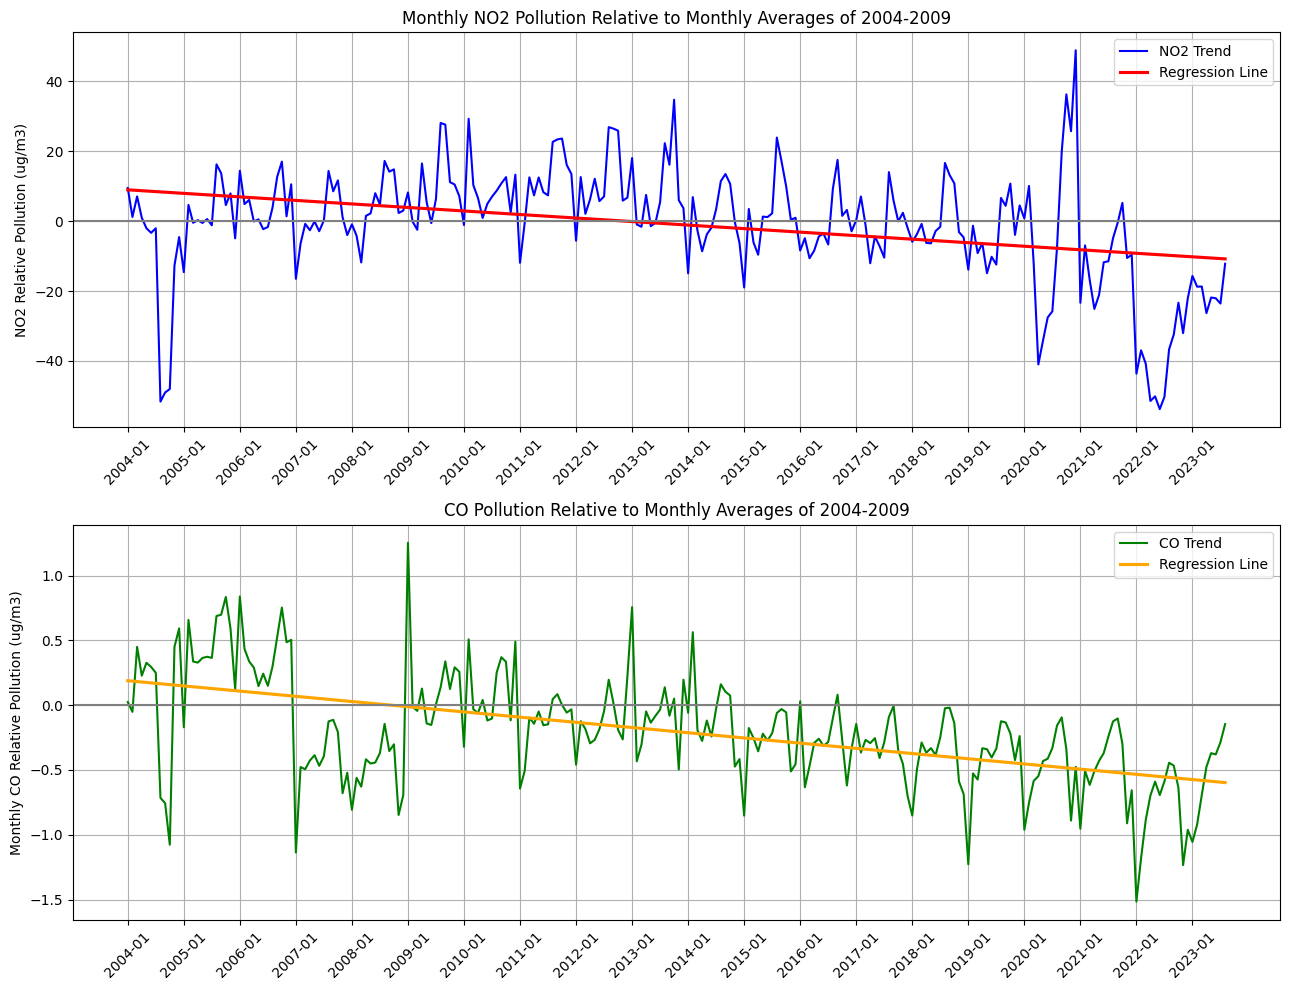

In [ ]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(13, 10))

sns.lineplot(x=np.arange(len(krakow_monthly_relative_pollution_df)), y='NO2', data=krakow_monthly_relative_pollution_df, ax=ax1, label='NO2 Trend', color='blue')
sns.regplot(x=np.arange(len(krakow_monthly_relative_pollution_df)), y='NO2', data=krakow_monthly_relative_pollution_df, ax=ax1, scatter=False, ci=False, color='red', label='Regression Line')
ax1.axhline(0, color='grey', linestyle='-')
ax1.set_title('Monthly NO2 Pollution Relative to Monthly Averages of 2004-2009')
ax1.set_ylabel('NO2 Relative Pollution (ug/m3)')
ax1.set_xticks(np.arange(0, len(krakow_monthly_relative_pollution_df), 12))
ax1.set_xticklabels(krakow_monthly_relative_pollution_df.index.strftime('%Y-%m').tolist()[::12], rotation=45)
ax1.grid(True)
ax1.legend()

sns.lineplot(x=np.arange(len(krakow_monthly_relative_pollution_df)), y='CO', data=krakow_monthly_relative_pollution_df, ax=ax2, label='CO Trend', color='green')
sns.regplot(x=np.arange(len(krakow_monthly_relative_pollution_df)), y='CO', data=krakow_monthly_relative_pollution_df, ax=ax2, scatter=False, ci=False, color='orange', label='Regression Line')
ax2.axhline(0, color='grey', linestyle='-')
ax2.set_title('CO Pollution Relative to Monthly Averages of 2004-2009')
ax2.set_ylabel('Monthly CO Relative Pollution (ug/m3)')
ax2.set_xticks(np.arange(0, len(krakow_monthly_relative_pollution_df), 12))
ax2.set_xticklabels(krakow_monthly_relative_pollution_df.index.strftime('%Y-%m').tolist()[::12], rotation=45)
ax2.grid(True)
ax2.legend()

plt.tight_layout()
plt.show()


**Insights**:
* NO2 Pollution: There are notable spikes and dips, with a general downward trend over the years. This might be due to improved regulations, changes in vehicle emissions, or industrial practices.

* CO Pollution: The trend is relatively stable with a slight increase in recent years. The stability might be due to consistent sources of CO, such as vehicular traffic or certain industrial activities.

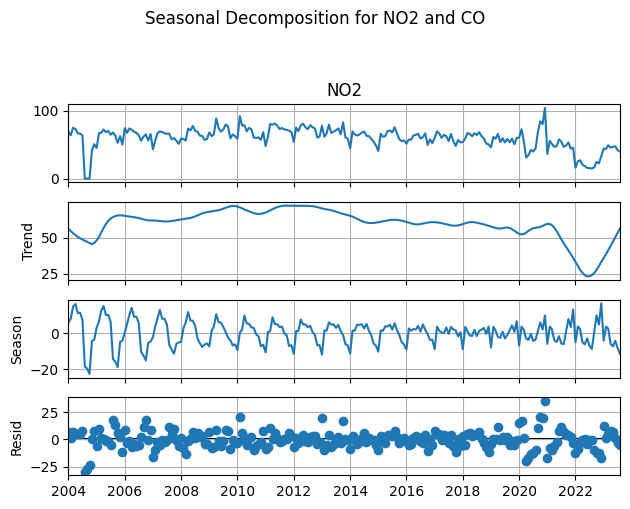

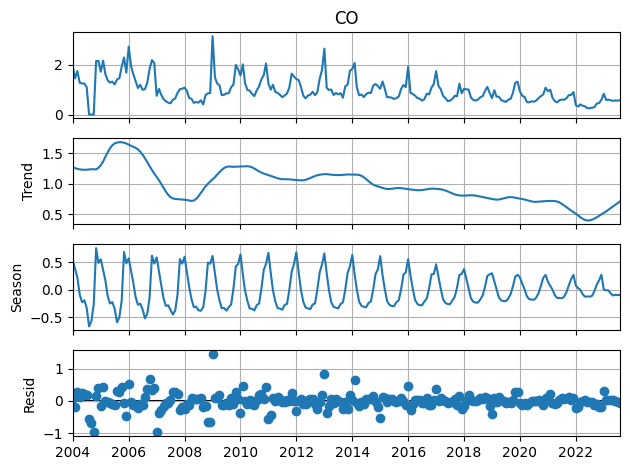

In [ ]:
stl_NO2 = STL(pollution_krakow_df['NO2'], seasonal=13).fit()
fig_NO2 = stl_NO2.plot()
for ax in fig_NO2.get_axes():
    ax.grid(True)
fig_NO2.suptitle('Seasonal Decomposition for NO2 and CO', y=1.05)
plt.tight_layout()
plt.show()

stl_CO = STL(pollution_krakow_df['CO'], seasonal=13).fit()
fig_CO = stl_CO.plot()
for ax in fig_CO.get_axes():
    ax.grid(True)
plt.tight_layout()
plt.show()

**Insights:**
* Trends: <br> Both CO and NO2 levels show a decline, indicating that air quality with respect to these pollutants might be improving. The causes might be due to environmental regulations, better technologies, or reduced industrial activities.

* Seasonality: <br> Both pollutants showcase a cyclical pattern every year. This could be attributed to factors like winter heating, vehicular pollution, and industrial output. Such patterns are common in cities with pronounced seasons and can be influenced by local practices and regulations.

* Residuals: <br> The residuals in both charts are randomly scattered, indicating that the seasonal decomposition has effectively captured the main trends and cycles.

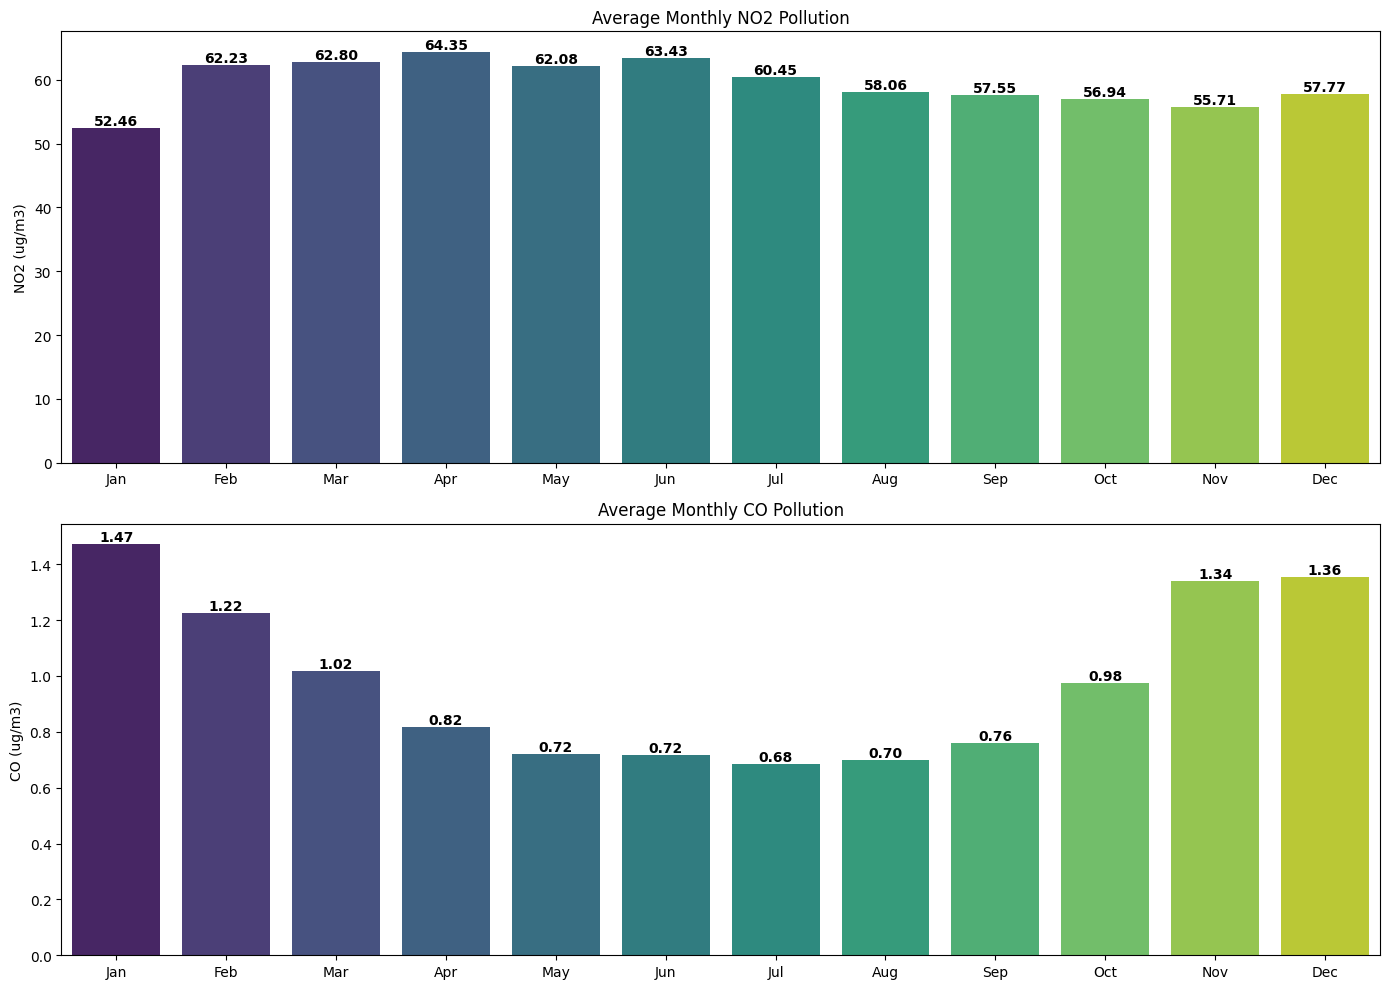

In [ ]:
pollution_krakow_df['month'] = pollution_krakow_df.index.month

monthly_avg_NO2 = pollution_krakow_df.groupby('month')['NO2'].mean()
monthly_avg_CO = pollution_krakow_df.groupby('month')['CO'].mean()

months = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10))


sns.barplot(x=months, y=monthly_avg_NO2, ax=ax1, palette="viridis")
ax1.set_title('Average Monthly NO2 Pollution')
ax1.set_ylabel('NO2 (ug/m3)')
for idx, value in enumerate(monthly_avg_NO2):
    ax1.text(idx, value, f"{value:.2f}", ha="center", va="bottom", fontweight='bold')


sns.barplot(x=months, y=monthly_avg_CO, ax=ax2, palette="viridis")
ax2.set_title('Average Monthly CO Pollution')
ax2.set_ylabel('CO (ug/m3)')
for idx, value in enumerate(monthly_avg_CO):
    ax2.text(idx, value, f"{value:.2f}", ha="center", va="bottom", fontweight='bold')

plt.tight_layout()
plt.show()


**Insights**
* Winter Effect:<br> Both NO2 and CO have higher values in the early months, January to March, which may suggest increased pollution due to winter heating, more combustion, or other seasonal factors.

* Stabilization in Summer:<br> Both pollutants show stable or slightly decreasing values from May to August, indicating a possible reduction in emission sources or better dispersion during warmer months.

* Late-Year Rise:<br> While NO2 remains fairly constant toward the year-end, CO sees a rise in the later months, perhaps pointing to an increase in combustion sources or changing weather patterns affecting pollutant dispersion.

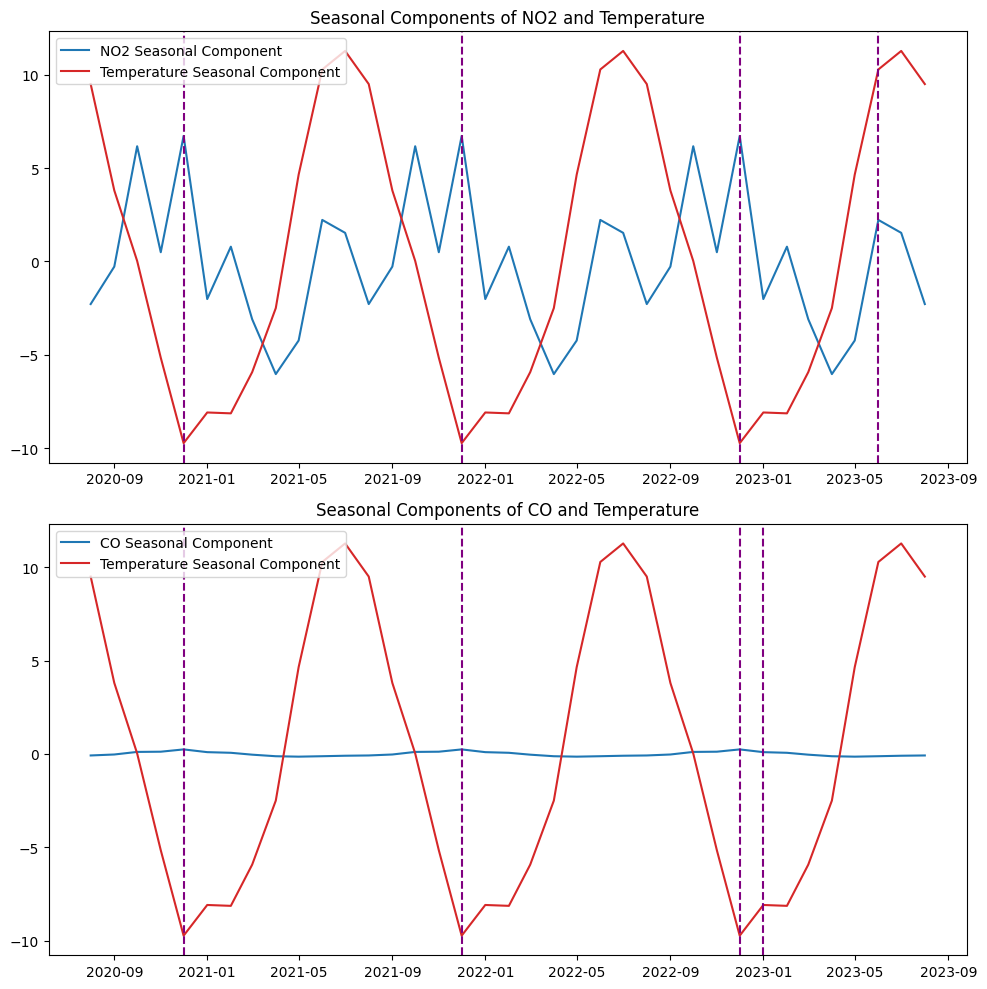

In [ ]:
end_date = krakow_temp_df.index.max()
start_date = end_date - pd.DateOffset(years=3)

filtered_temp_df = krakow_temp_df[(krakow_temp_df.index >= start_date) & (krakow_temp_df.index <= end_date)]
filtered_pollution_df = pollution_krakow_df[(pollution_krakow_df.index >= start_date) & (pollution_krakow_df.index <= end_date)]

merged_df = pd.merge(filtered_temp_df, filtered_pollution_df, left_index=True, right_index=True)

no2_seasonal = seasonal_decompose(merged_df['NO2'], model='additive', period=12).seasonal
temp_seasonal = seasonal_decompose(merged_df['Average monthly temperature [°C]'], model='additive', period=12).seasonal
co_seasonal = seasonal_decompose(merged_df['CO'], model='additive', period=12).seasonal

fig, axes = plt.subplots(2, 1, figsize=(10, 10))


axes[0].plot(no2_seasonal, label='NO2 Seasonal Component', color='tab:blue')
axes[0].plot(temp_seasonal, label='Temperature Seasonal Component', color='tab:red')
for year in range(start_date.year, end_date.year + 1):
    max_no2_for_year = no2_seasonal[str(year)].idxmax()
    axes[0].axvline(x=max_no2_for_year, color='purple', linestyle='--')
axes[0].set_title('Seasonal Components of NO2 and Temperature')
axes[0].legend()


axes[1].plot(co_seasonal, label='CO Seasonal Component', color='tab:blue')
axes[1].plot(temp_seasonal, label='Temperature Seasonal Component', color='tab:red')
for year in range(start_date.year, end_date.year + 1):
    max_co_for_year = co_seasonal[str(year)].idxmax()
    axes[1].axvline(x=max_co_for_year, color='purple', linestyle='--')
axes[1].set_title('Seasonal Components of CO and Temperature')
axes[1].legend()

plt.tight_layout()
plt.show()


**NO2 and Temperature Seasonal Components**

Dips in the temperature component align with peaks in the NO2 component, and vice versa. This inverse relationship suggests that when temperatures rise, NO2 concentrations decrease, and when temperatures fall, NO2 concentrations increase.

**CO and Temperature Seasonal Components**

Similar to the NO2 component, there's an inverse relationship between the seasonal components of CO and temperature. Higher temperatures correlate with lower CO concentrations and lower temperatures with higher CO concentrations.

**Conclusion**

The inverse relationship between temperature and both NO2 and CO concentrations might indicate that colder months lead to increased emissions, possibly due to factors like increased heating, vehicular usage, or other combustion processes.
The patterns are consistent across the years, suggesting that these seasonal variations are repetitive and can be anticipated.

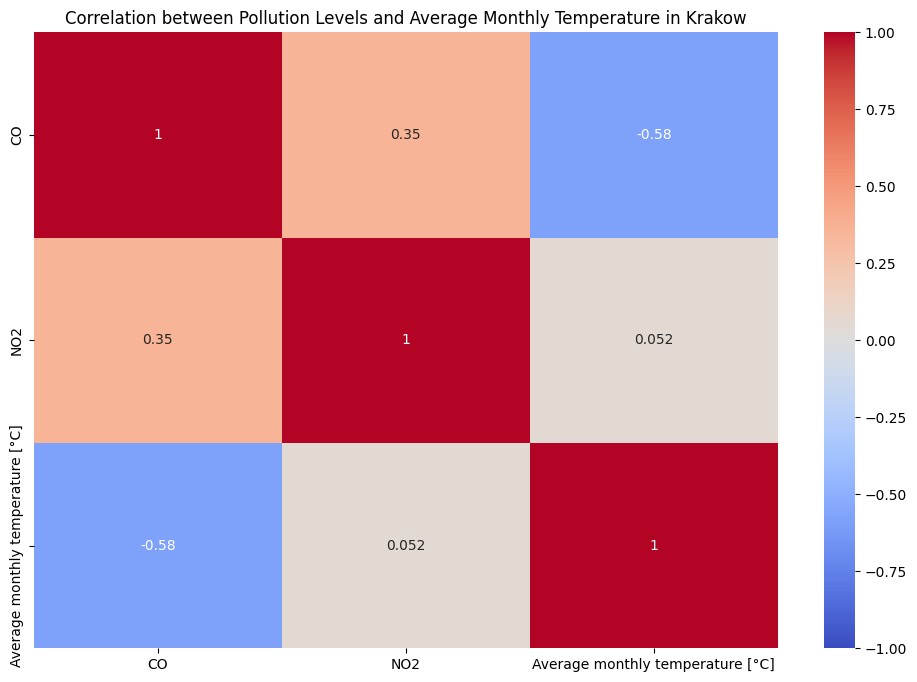

In [ ]:
merged_df = pd.merge(pollution_krakow_df[['CO','NO2']], krakow_temp_df[['Average monthly temperature [°C]']], left_index=True, right_index=True)

correlation_matrix = merged_df.corr()

plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", vmin=-1, vmax=1)
plt.title('Correlation between Pollution Levels and Average Monthly Temperature in Krakow')
plt.show()


**Insights**
* CO vs Temperature: <br>There's a negative correlation of -0.58 between CO levels and average monthly temperature. As temperature increases, CO levels tend to decrease.

* NO2 vs Temperature: <br>The correlation is 0.036, which is near zero, indicating a very weak or no linear relationship between NO2 levels and average monthly temperature, yet we still have data on peak pollution.

* CO vs NO2: <br>There's a positive correlation of 0.36, suggesting that as CO levels increase, NO2 levels also tend to increase, but not very strongly.

The main takeaway is that CO levels have a moderate inverse relationship with temperature, while NO2 does not have a strong correlation with temperature in Krakow. Hence, we have proven that high pollution indeed has inverse relationship with lower temperatures.

# Global Warming and Its Growing Influence on Heat Inversions: Insights from Italy and Beyond

In our comprehensive analysis of Krakow's pollution influence and climatic changes, an important perspective is gained by considering broader research on global warming and its impacts on local weather phenomena like heat inversions. A study focusing on Italy, as mentioned in the article "[Changes in occurrence of temperature inversions in connection with atmospheric circulation](https://www.sciencedirect.com/science/article/abs/pii/S0169809516304136)", offers valuable insights. This study is part of a growing body of evidence showing how global warming influences local climatic events.

### Key Findings from the Italian Study
The study conducted in Italy provides specific findings on heat inversions which can be generalized to understand the potential impacts in similar regions, including Krakow:

* **Increased Frequency of Inversions**: One of the significant observations is an increase in the frequency of temperature inversions, particularly during certain seasons, as global temperatures rise.
* **Variable Intensity and Duration**: The study notes variability in the intensity and duration of these inversions, suggesting a complex interplay with changing global and regional climatic conditions.
* **Link to Atmospheric Circulation Changes**: The alterations in atmospheric circulation patterns, driven by global warming, are highlighted as key contributors to these changes in inversion characteristics.

### Implications for Krakow and Similar Regions
Although the study focuses on Italy, its findings are indicative of a broader trend that can be relevant for Krakow. The city's geographic and climatic conditions make it susceptible to similar patterns observed in the Italian study:

* **Rising Local Pollution**: With an expected increase in the frequency of heat inversions due to global warming, Krakow might witness a corresponding rise in local pollution levels. This is particularly relevant given the city's existing challenges with air quality.
* **Necessity for Comprehensive Climate Strategies**: This underlines the need for integrated climate strategies in Krakow that address both global emissions and local environmental management.

# Summary
In this project, we have investigated the influence of global pollution on both global and local temperature changes in Krakow city, as well as the impact of the heat inversion phenomenon on local air pollution in Krakow.

Adding to our analysis, the insights from an Italian study provide a crucial global perspective. This study reinforces the potential link between increased global warming and the frequency of local heat inversions, which, in turn, lead to elevated local pollution levels in Krakow. This interconnection underscores the importance of considering both global and local environmental strategies in Krakow's approach to managing and mitigating the impacts of climate change on urban air quality and public health.

The project holds significant implications for energy policy, particularly initiatives aimed at replacing conventional energy sources with alternative ones. By understanding the relationship between global pollution, local temperature increases, and the effects of heat inversion on air quality, our project offers valuable data that can guide the integration of renewable energy sources like wind and solar power. This transition to cleaner energy options is particularly relevant for Krakow, as it could mitigate some of the environmental challenges identified. Utilizing alternative energy sources could reduce the city's contribution to global pollution and alleviate local pollution levels, especially during cold months when heat inversions are prevalent.

Furthermore, this project opens opportunities for further research in climate adaptation strategies, urban planning, and public health policies in Krakow. The findings can be utilized to develop localized solutions for mitigating temperature increases and managing air quality. The insights gained could also serve as a valuable case study for other cities facing similar environmental challenges, aiding in the formulation of broader global pollution reduction initiatives.